In [1]:
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

In [2]:
os.chdir('..') # change working directory to root

In [3]:
from utilities import mimic_iii_funcs
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from mdp.mimic_iii.reward_functions.abstract_reward_function import AbstractRewardFunction
from mdp.mimic_iii.reward_functions.factory import Factory as RewardFnFactory
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace

In [4]:
# reward function details dict
reward_fn_details_dict = {
    'sparse': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/vm/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '97629e709d7f45ec851200c6b0d497df',
        'd3qn_run_id': '5944007810ef4e318106533adbd6ccb6',
        'd3qn_magic_run_id': '85de6b80c8374e489bb49164bcbf29a5',
        'ddpg_run_id': 'cba965ed952945a1a0d9660d807cf2a0',
        'ddpg_magic_run_id': 'f835cde18011478693931ecc0247df63',
    },
    'wu': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '6dd75e96646b45938f225f3964705324',
        'd3qn_run_id': '5d140bdb06e344bd888876561f010f0e',
        'd3qn_magic_run_id': 'fd3f75118286426f88ca127246e33cda',
        'ddpg_run_id': '67c02a6bab0b4d74aadf585f7c8edd87',
        'ddpg_magic_run_id': '18ed010dada041f79639230d54ca5db7',
    },
    'yong': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': 'ecac4334f1994260b2bcd420b671c53a',
        'd3qn_run_id': '8f098fb13a5b41da9e77dac2ae13d321',
        'd3qn_magic_run_id': '29ad84ac64ed4ab98f7e10488887f301',
        'ddpg_run_id': '30cccf0e3c2c4ffaa1a9ea1c2bf23972',
        'ddpg_magic_run_id': '7ecad48fb0e04388b048d183b195e5f8',
    },
    'raghu': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '17d5de3272cb4e2892e6e438d22c2af4',
        'd3qn_run_id': '9a5d00e3454840499ce4697fa6bf472c',
        'd3qn_magic_run_id': 'd2584eef61284bc4bc9d57402927b750',
        'ddpg_run_id': 'da45045dfb1042d1a21a06360ca55239',
        'ddpg_magic_run_id': '01c5faa0f8ee4a5b9cb08a712060dc0e',
    },
    'peng': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '1e6330b7604f4aad8da905239c1b5070',
        'd3qn_run_id': '37d3ea87328d4c94a75c5d6e0011495a',
        'd3qn_magic_run_id': '68161afeb1ff41bbbc795f91e6a42c5b',
        'ddpg_run_id': 'b008b48ce39d4847ae2d377b4cbb91ba',
        'ddpg_magic_run_id': '2d6c08b95c8e40c2a6a0473a3b12f737',
        'reward_fn_run_id': '211c5a3c31f147f38d63b6b357a7b610',
    },
}

In [48]:
def load_reward_fn(reward_fn_name_: str, reward_fn_results_dict_: Dict[str, str], split_: int) -> AbstractRewardFunction:
    reward_fn_ = RewardFnFactory.create(reward_fn_name_)
    if reward_fn_name_ == 'peng':
        peng_run_id = reward_fn_results_dict_['reward_fn_run_id']
        reward_fn_.load(f'runs:/{peng_run_id}/split_{split_}')
    return reward_fn_

def load_split_test_data(split: int, reward_fn_name_: str, reward_fn: AbstractRewardFunction, behavior_policy: KMeansSarsa) -> pd.DataFrame:
    # load and preprocess mimic data
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split, reward_fn.raw_data_columns)
    if reward_fn_name_ != 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
        discrete_mimic_df = mimic_iii_funcs.drop_all_raw_data_columns(discrete_mimic_df)
    discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'mortality_plots')
    discrete_mimic_df['mortality'] = ~discrete_mimic_df['survived']
    if reward_fn_name_ == 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
    train_df, val_df, test_df = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'kmeans_sarsa')
    test_df['discrete_state'] = behavior_policy.discretize_states(np.vstack(test_df['state'].to_numpy()).astype(np.float32))
    test_df['discrete_next_state'] = behavior_policy.discretize_states(np.vstack(test_df['next_state'].to_numpy()).astype(np.float32))
    return test_df

def compute_behavior_policy_return(traj_df: pd.DataFrame, gamma: float) -> float:
    unique_trajs = traj_df['traj'].unique()
    expected_return = 0.0
    for traj_num in unique_trajs:
        traj_view = traj_df.loc[traj_df['traj'] == traj_num].sort_values('step', ascending=True)
        rewards = traj_view['r:reward'].to_numpy()
        gammas = np.cumprod(np.full((rewards.shape[0],), gamma))
        expected_return += np.dot(rewards, gammas)
    expected_return /= unique_trajs.shape[0]
    return expected_return

def compute_learned_behavior_policy_return(traj_df: pd.DataFrame, behavior_policy_: KMeansSarsa) -> float:
    unique_trajs = traj_df['traj'].unique()
    expected_return = 0.0
    for traj_num in unique_trajs:
        traj_view = traj_df.loc[(traj_df['traj'] == traj_num) & (traj_df['step'] == 0)]
        states = traj_view['discrete_state'].to_numpy()
        actions = traj_view['a:action'].to_numpy()
        q_val = behavior_policy_._Q[states, actions]
        expected_return += q_val.item()
    expected_return /= unique_trajs.shape[0]
    return expected_return

def bin_expected_returns(df_: pd.DataFrame, behavior_policy_: KMeansSarsa) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df_['expected_return'] = behavior_policy_.get_q_values(df_['discrete_state'].to_numpy(), df_['a:action'].to_numpy())
    df_['return_bin'] = -1
    min_q_val_bin = int(np.floor(df_['expected_return'].min()))
    max_q_val_bin = int(np.ceil(df_['expected_return'].max()))
    q_val_bins = np.arange(min_q_val_bin, max_q_val_bin + 1, dtype=np.int32)
    mortality_pct = np.full((q_val_bins.shape[0],), 0.5, dtype=np.float32)
    mortality_std = np.full((q_val_bins.shape[0],), 0.245, dtype=np.float32)
    mortality_sem = np.full((q_val_bins.shape[0],), 0.245, dtype=np.float32)
    for bin_num in q_val_bins:
        bin_mask = (df_['expected_return'] >= bin_num - 0.5) & (df_['expected_return'] < bin_num + 0.5)
        df_.loc[bin_mask, 'return_bin'] = bin_num
        slice_mortality_count = df_.loc[bin_mask, 'mortality'].sum().item()
        num_states_in_bin = bin_mask.sum()
        if num_states_in_bin > 0:
            mortality_pct[bin_num - min_q_val_bin] = slice_mortality_count / num_states_in_bin
            mortality_std[bin_num - min_q_val_bin] = np.std(df_.loc[bin_mask, 'mortality'].to_numpy())
            mortality_sem[bin_num - min_q_val_bin] = np.std(df_.loc[bin_mask, 'mortality'].to_numpy()) / np.sqrt(num_states_in_bin)
    return q_val_bins, mortality_pct, mortality_std, mortality_sem

def do_mortality_vs_expected_return_plot(df_: pd.DataFrame, behavior_policy_: KMeansSarsa, magic_expected_return: float, fqe_expected_return: float):
    q_val_bins, mortality_pct, mortality_std, mortality_sem = bin_expected_returns(df_, behavior_policy_)
    f, ax0 = plt.subplots(1, 1, figsize=(8,4))
    sns.lineplot(df_, x='return_bin', y='mortality', ax=ax0)
    ax0.set_xlabel('Expected return')
    ax0.set_ylabel('Mortality')
    ax0.set_title('Mortality vs Expected Return')
    ax0.axvline(x=magic_expected_return, color='r', linestyle='--', label='MAGIC Expected Return')
    ax0.axvline(x=fqe_expected_return, color='g', linestyle='--', label='FQE Expected Return')
    #sns.lineplot(x=q_val_bins, y=mortality_pct, ax=ax1)
    # ax1.fill_between(q_val_bins, mortality_pct - mortality_std, mortality_pct + mortality_std, alpha=0.2)
    # ax1.set_xlabel('Expected return')
    # ax1.set_ylabel('Mortality')
    # ax1.set_title('Mortality vs Expected Return')
    df_.drop(columns=['expected_return', 'return_bin'], inplace=True)
    plt.show()

def load_behavior_policy(result_dict: Dict[str, float], split: int) -> KMeansSarsa:
    run_id = result_dict['behavior_policy_run_id']
    behavior_policy = KMeansSarsa(n_clusters=8, n_actions=len(DiscreteActionSpace), num_episodes=1, reward_scale=15.0)
    behavior_policy.load_model(run_id, f'split_{split}')
    return behavior_policy

def compute_mortality_pct_from_expected_return(q_val_bins: np.ndarray, mortality_pct: np.ndarray, expected_return: float) -> float:
    rounded_return_expectation = int(np.round(expected_return))
    bin_num = rounded_return_expectation - q_val_bins[0]
    if bin_num < 0:
        return mortality_pct[0]
    elif bin_num >= q_val_bins.shape[0]:
        return mortality_pct[-1]
    else:
        print(f'Bin Num: {bin_num} Mortality_pct dim: {mortality_pct.shape}')
        return mortality_pct[bin_num]

def extract_and_plot_mortality_vs_expected_return_for_split(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]], split: int):
    reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
    reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
    behavior_policy = load_behavior_policy(reward_fn_results_dict, split)
    test_df = load_split_test_data(split, reward_fn_name, reward_fn, behavior_policy)
    magic_expected_returns, fqe_expected_returns = extract_ope_results(reward_fn_name, reward_fn_results_dict)
    magic_expected_return, fqe_expected_return = magic_expected_returns[split], fqe_expected_returns[split]
    do_mortality_vs_expected_return_plot(test_df, behavior_policy, magic_expected_return, fqe_expected_return)

def extract_ope_results(reward_fn_name: str, reward_fn_details_dict_: Dict[str, str]) -> Tuple[List[float], List[float]]:
    client = mlflow.MlflowClient(tracking_uri=reward_fn_details_dict_['mlflow_base_path'])
    metric_history = client.get_metric_history(reward_fn_details_dict_['d3qn_magic_run_id'], 'magic')
    magic_expected_returns = [metric.value for metric in metric_history]
    metric_history = client.get_metric_history(reward_fn_details_dict_['d3qn_magic_run_id'], 'fqe')
    fqe_expected_returns = [metric.value for metric in metric_history]
    return magic_expected_returns, fqe_expected_returns

def extract_mortality_pct(test_df: pd.DataFrame) -> float:
    unique_traj_view = test_df[test_df['step'] == 0]
    return unique_traj_view['mortality'].sum() / unique_traj_view.shape[0]

def extract_and_print_mortality_result_table(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]]):
    reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
    mlflow.set_tracking_uri(reward_fn_results_dict['mlflow_base_path'])
    magic_expected_returns, fqe_expected_returns = extract_ope_results(reward_fn_name, reward_fn_results_dict)
    learned_behavior_return, phys_mortality_approx, magic_mortality_approx, fqe_mortality_approx, test_data_mortality_pct = list(), list(), list(), list(), list()
    for split in range(10):
        reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
        behavior_policy = load_behavior_policy(reward_fn_results_dict, split)
        test_df = load_split_test_data(split, reward_fn_name, reward_fn, behavior_policy)
        test_data_mortality_pct.append(extract_mortality_pct(test_df))
        learned_behavior_return.append(compute_learned_behavior_policy_return(test_df, behavior_policy))
        q_val_bins, mortality_pct, mortality_std, mortality_sem = bin_expected_returns(test_df, behavior_policy)
        phys_mortality_approx.append(compute_mortality_pct_from_expected_return(q_val_bins, mortality_pct, learned_behavior_return[-1]))
        magic_mortality_approx.append(compute_mortality_pct_from_expected_return(q_val_bins, mortality_pct, magic_expected_returns[split]))
        fqe_mortality_approx.append(compute_mortality_pct_from_expected_return(q_val_bins, mortality_pct, fqe_expected_returns[split]))
    print(f'Test Data Mortality: {np.mean(test_data_mortality_pct)} +/- {np.std(test_data_mortality_pct)}')
    print(f'Learned Behavior Policy Return: {np.mean(learned_behavior_return)} +/- {np.std(learned_behavior_return)}')
    print(f'Physician Mortality Approximation: {np.mean(phys_mortality_approx)} +/- {np.std(phys_mortality_approx)}')
    print(f'MAGIC Expected Return: {np.mean(magic_expected_returns)} +/- {np.std(magic_expected_returns)}')
    print(f'MAGIC Mortality Approximation: {np.mean(magic_mortality_approx)} +/- {np.std(magic_mortality_approx)}')
    print(f'FQE Expected Return: {np.mean(fqe_expected_returns)} +/- {np.std(fqe_expected_returns)}')
    print(f'FQE Mortality Approximation: {np.mean(fqe_mortality_approx)} +/- {np.std(fqe_mortality_approx)}')

In [39]:
extract_and_print_mortality_result_table('sparse', reward_fn_details_dict)

Test Data Mortality: 0.19364395367627257 +/- 2.7755575615628914e-17
Learned Behavior Policy Return: 8.902496115323528 +/- 0.03511020408072673
Physician Mortality Approximation: 0.21564383804798126 +/- 0.006888022646307945
MAGIC Expected Return: 12.76890001296997 +/- 14.158017654877268
MAGIC Mortality Approximation: 0.2663845121860504 +/- 0.40360939502716064
FQE Expected Return: 4.951464453125 +/- 0.4089828093716974
FQE Mortality Approximation: 0.3911542296409607 +/- 0.045238617807626724


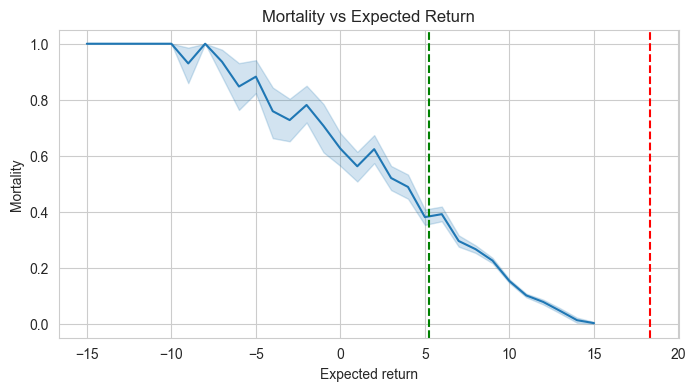

In [20]:
extract_and_plot_mortality_vs_expected_return_for_split('sparse', reward_fn_details_dict, 3)

In [43]:
extract_and_print_mortality_result_table('wu', reward_fn_details_dict)

Test Data Mortality: 0.19364395367627257 +/- 2.7755575615628914e-17
Learned Behavior Policy Return: 14.275022609802926 +/- 0.07651923269472573
Physician Mortality Approximation: 0.23589634895324707 +/- 0.009819685481488705
MAGIC Expected Return: 22.834936451911926 +/- 24.220836221991192
MAGIC Mortality Approximation: 0.2864460349082947 +/- 0.3013433516025543
FQE Expected Return: 6.679338216145832 +/- 0.8009334766940748
FQE Mortality Approximation: 0.44218239188194275 +/- 0.04505976289510727


In [49]:
extract_and_print_mortality_result_table('yong', reward_fn_details_dict)

Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 2 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Bin Num: 1 Mortality_pct dim: (3,)
Test Data Mortality: 0.19364395367627257 +/- 2.7755575615628914e-17
Learned Behavior Polic

In [50]:
extract_and_print_mortality_result_table('raghu', reward_fn_details_dict)

Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 7 Mortality_pct dim: (31,)
Bin Num: 21 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 23 Mortality_pct dim: (31,)
Bin Num: 19 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 25 Mortality_pct dim: (31,)
Bin Num: 19 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 20 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 1 Mortality_pct dim: (31,)
Bin Num: 20 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 15 Mortality_pct dim: (31,)
Bin Num: 21 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 10 Mortality_pct dim: (31,)
Bin Num: 20 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 28 Mortality_pct dim: (31,)
Bin Num: 19 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 20 Mortality_pct dim: (31,)
Bin Num: 24 Mortality_pct dim: (31,)
Bin Num: 20 Mortality_pct dim: (31,)
Tes